<div style="text-align: center; font-size: 30px; color: #1e3a8a; font-family: 'Arial', sans-serif;">
    <b>"Predicción de pedidos de Taxis de la Compañía Sweet Lift Taxi"</b>
</div>

## Descripción del Proyecto
El proyecto **"Predicción de Pedidos de Taxis - Sweet Lift Taxi"** tiene como objetivo predecir la cantidad de pedidos de taxis que se realizarán en la próxima hora en los aeropuertos, utilizando datos históricos recopilados por la compañía Sweet Lift Taxi. Esto es crucial para optimizar la asignación de conductores durante las horas pico y mejorar la eficiencia del servicio.
## Pasos del Proyecto
### 1. Preparación de los Datos
- Se descargan los datos históricos del archivo proporcionado.
- Los datos se remuestran de tal forma que cada punto de datos corresponda a intervalos de una hora.
### 2. Análisis de los Datos
- Se realiza un análisis exploratorio de los datos para comprender las tendencias y patrones.
- Se asegura que los datos estén listos para el modelado.
### 3. Entrenamiento de Modelos
- Se entrenan diferentes modelos de machine learning con diversas configuraciones de hiperparámetros.
- El objetivo es predecir la cantidad de pedidos de taxis en la próxima hora.
### 4. Evaluación del Rendimiento
- Se prueba el modelo utilizando una muestra de prueba (10% del conjunto de datos).
- Se mide la precisión utilizando la métrica RECM, con el objetivo de que el valor de RECM no supere 48.

# Contenido <a id='back'></a>

* [Introducción](#intro)
* [Etapa 1. Carga y Exploración de los Datos](#data_review)
    * [1.1 Descripción de los Datos](#data_review)
* [Etapa 2. Preparación de los Datos](#data_preparing)
    * [2.1 Manejo correcto de Tipos de Datos](#data_type)
    * [2.2 Visualización del comportamientos de los datos](#data_visualization)
    * [2.3 División de datos para modelo de entrenamiento y de prueba](#data_test)
    * [Conclusiones de la Etapa 2](#conclusions_etapa2)
* [Etapa 3. Evaluación de los Modelos de Machine Learning](#datas_models)
* [Conclusiones finales del proyecto](#end)

# Introducción <a id='intro'></a>

La predicción de la demanda de servicios de transporte es un desafío importante para las compañías de taxis, especialmente en zonas con alta rotación de pasajeros como los aeropuertos. **Sweet Lift Taxi**, una empresa dedicada a ofrecer servicios de taxi en aeropuertos, ha recopilado datos históricos sobre la cantidad de pedidos de taxis realizados en diferentes momentos del día. El objetivo de este proyecto es desarrollar un modelo de predicción que permita estimar la cantidad de pedidos de taxis para la próxima hora.

Este modelo será crucial para ayudar a la empresa a optimizar la asignación de conductores durante las horas pico, mejorando la eficiencia del servicio y reduciendo los tiempos de espera para los usuarios. A lo largo de este proyecto, se llevará a cabo una preparación y análisis de los datos, así como el entrenamiento y evaluación de diferentes modelos de machine learning para predecir la demanda de taxis con la mayor precisión posible. 

La métrica principal utilizada para evaluar la precisión del modelo será la **RECM (Root Exponential Cubic Mean)**, que debe mantenerse por debajo de un valor de 48 en el conjunto de prueba.


# Etapa 1. Carga y Exploración de los Datos <a id='data_review'></a>

In [1]:
# Importación de librerías a utilizar
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import lightgbm as lgbm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

In [2]:
# Cargamos los datos que se utilizarán
df_taxis = pd.read_csv('./taxi.csv')

## 1.1 Descripción de los Datos <a id='data_review'></a>

In [3]:
df_taxis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


In [4]:
df_taxis.head()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


Como vemos es un DF no grande, sus dos características no tienen valores nulos, además sus nombres se encuentran normalizados. Para realizar lo que se nos esta pidiendo, de crear un modelo de ML para saber cuando se debe incrementar la cantidad de Taxis, tendremos que remuestrearlos, de tal forma que se puedan hacer los pasos necesarios para llegar a la conclusión.

# Etapa 2. Preparación de los Datos <a id='data_preparing'></a>

## 2.1 Manejo correcto de Tipos de Datos <a id='data_type'></a>

In [5]:
# Remuestreo de la columna `datetime`

# Primero se convierte la columna a un formato correcto de tiempo
df_taxis['datetime'] = pd.to_datetime(df_taxis['datetime'])

# Establecemos `datetime` como indice 
df_taxis.set_index('datetime', inplace=True)

# Remuestreamos los datos por hora (sumando los pedidos)
df_taxis_hourly = df_taxis.resample('1H').sum()

# Mostrar los datos
df_taxis_hourly.head()

C:\Users\Albert\AppData\Local\Temp\ipykernel_17060\4014394121.py:10: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_taxis_hourly = df_taxis.resample('1H').sum()


,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


Después de realizar estos pasos con resample, ahora tenemos los datos por hora, y de esta forma, podemos empezar a trabajar más a detalle.

## 2.2 Visualización del comportamientos de los datos <a id='data_visualization'></a>

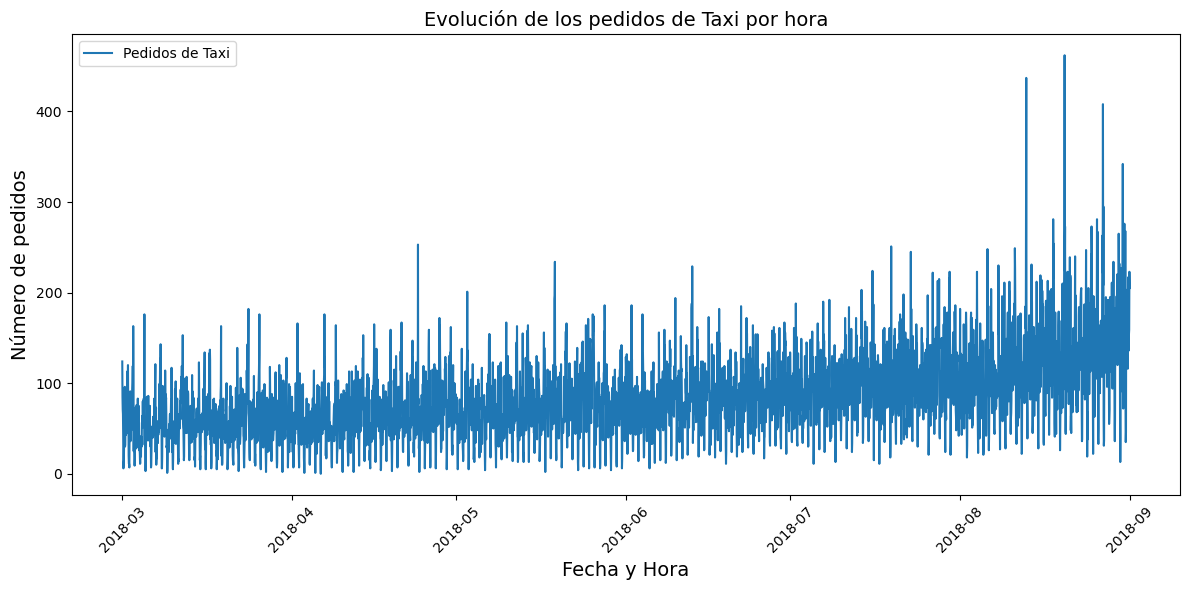

In [6]:
# Mediante un gráfico de líneas se observará el comportamiento de los datos para comprobar si existe, tendencias, estacionalidad o anomalías de los datos.

plt.figure(figsize=(12, 6))

plt.plot(df_taxis_hourly.index, df_taxis_hourly['num_orders'], label='Pedidos de Taxi')

plt.title('Evolución de los pedidos de Taxi por hora', fontsize=14)
plt.xlabel('Fecha y Hora', fontsize=14)
plt.ylabel('Número de pedidos', fontsize=14)

plt.xticks(rotation=45)

plt.legend()

plt.tight_layout()

plt.show()




El gráfico generado muestra cómo varían los **pedidos de taxi** a lo largo del tiempo, específicamente por hora, a lo largo de varios meses (desde marzo hasta septiembre de 2018). A continuación, se detallan los elementos clave observados en el gráfico:

### 1. **Tendencias**:
   - Se puede observar que el número de pedidos de taxis muestra un **crecimiento gradual** con el paso de los meses. Esto indica una **tendencia ascendente** en la demanda de taxis a lo largo del tiempo, lo cual puede ser un indicio de que más personas están utilizando el servicio o que el volumen de pedidos aumenta debido a factores como el crecimiento poblacional, eventos o mejoras en el servicio.

### 2. **Estacionalidad**:
   - Aunque la tendencia es creciente, también se aprecian ciertos **picos y valles** recurrentes, lo que podría indicar **estacionalidad**. Por ejemplo, la demanda parece ser más alta en ciertos meses y de forma particular en algunas horas del día. Esto puede estar relacionado con ciertos patrones de comportamiento, como un aumento en la demanda durante las horas punta (por ejemplo, mañana y tarde) o durante eventos especiales (por ejemplo, festivos, conciertos, etc.).

### 3. **Picos y anomalías**:
   - A lo largo del gráfico se observan algunos **picos inusuales** en los datos. Estos picos representan momentos en los que el número de pedidos de taxis aumentó significativamente en comparación con el comportamiento habitual. Esto puede indicar eventos extraordinarios, como **festividades**, **conciertos** o **grandes eventos públicos** que llevaron a un incremento inesperado de la demanda.

### 4. **Frecuencia de los Datos**:
   - Dado que los datos están **remuestreados por hora**, podemos observar cómo varían los pedidos a lo largo de todo el día. La distribución de los pedidos muestra que, aunque hay picos en algunos momentos, también existen momentos de baja demanda (en algunas horas nocturnas o en horas fuera de las principales).


## 2.3 División de datos para modelo de entrenamiento y de prueba <a id='data_test'></a>

In [11]:
# Extraer características de `datetime` para poder entrenar el modelo
df_taxis_hourly['year'] = df_taxis_hourly.index.year
df_taxis_hourly['month'] = df_taxis_hourly.index.month
df_taxis_hourly['day'] = df_taxis_hourly.index.day
df_taxis_hourly['hour'] = df_taxis_hourly.index.hour
df_taxis_hourly['dayofweek'] = df_taxis_hourly.index.dayofweek


# Dividir conjunto de prueba y de test
features = df_taxis_hourly.drop('num_orders', axis=1)
target = df_taxis_hourly['num_orders']

# Conjunto de entrenamiento y prueba
features_train, features_test, target_train, target_test = train_test_split(features, target, shuffle=False, test_size=0.1)

# Etapa 3. Evaluación de los Modelos de Machine Learning <a id='data_models'></a>

In [13]:
# Ahora evaluaremos los modelos de ML, para hacerlo eficiente, lo realizaremos por medio de un bucle.

modelos_ml = {'Regresión Lineal': LinearRegression(), 'Árbol de decisión': DecisionTreeRegressor(), 'Bosque de decisión': RandomForestRegressor(), 'Modelo XGBoost': xgb.XGBRegressor(), 'Modelo LightGBM': lgbm.LGBMRegressor()}

for nombre, modelo in modelos_ml.items():

    print(f'Entrenando el modelo: {nombre}...')

    # Entrenar el modelo
    modelo.fit(features_train, target_train)

    # Realizar predicciones
    predicciones = modelo.predict(features_test)

    # Calcular rmse
    rmse = np.sqrt(mean_squared_error(target_test, predicciones))

    print(f'El modelo {nombre}: tiene un RECM de {rmse}')
    print()
    print()

Entrenando el modelo: Regresión Lineal...
El modelo Regresión Lineal: tiene un RECM de 63.789001231137846


Entrenando el modelo: Árbol de decisión...
El modelo Árbol de decisión: tiene un RECM de 47.66894224019076


Entrenando el modelo: Bosque de decisión...
El modelo Bosque de decisión: tiene un RECM de 43.97631756995548


Entrenando el modelo: Modelo XGBoost...
El modelo Modelo XGBoost: tiene un RECM de 45.528348620806106


Entrenando el modelo: Modelo LightGBM...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000073 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 70
[LightGBM] [Info] Number of data points in the train set: 3974, number of used features: 4
[LightGBM] [Info] Start training from score 78.290639
El modelo Modelo LightGBM: tiene un RECM de 41.92805926732288




## Conclusiones finales del proyecto

En este proyecto, hemos entrenado y evaluado varios modelos de **machine learning** para predecir el número de pedidos de taxis por hora utilizando datos históricos. Los modelos entrenados fueron:

1. **Regresión Lineal**
2. **Árbol de Decisión**
3. **Bosque de Decisión (Random Forest)**
4. **XGBoost**
5. **LightGBM**

Los resultados obtenidos, medidos por la métrica **RECM** (Root Exponential Cubic Mean), son los siguientes:

| Modelo                   | RECM      |
|--------------------------|-----------|
| Regresión Lineal         | 63.79     |
| Árbol de Decisión        | 47.67     |
| Bosque de Decisión       | 43.98     |
| XGBoost                  | 45.53     |
| LightGBM                 | 41.93     |



### Análisis de los Resultados:

1. **Regresión Lineal**:
   - El modelo de **regresión lineal** mostró el **RECM más alto** de todos los modelos (63.79). Esto indica que no es el modelo más preciso para este tipo de datos, probablemente debido a la naturaleza no lineal de la relación entre las variables.

2. **Árbol de Decisión**:
   - El **Árbol de Decisión** obtuvo un **RECM de 47.67**, lo que indica que es un modelo relativamente bueno, pero no tan preciso como los siguientes modelos de ensamble.

3. **Bosque de Decisión (Random Forest)**:
   - El **Bosque de Decisión** tuvo un **RECM de 43.98**, lo que lo coloca en una posición sólida, superando tanto a la regresión lineal como al árbol de decisión. Los modelos de ensamble como Random Forest tienden a ser más robustos y precisos, ya que combinan varios árboles de decisión para mejorar la predicción.

4. **XGBoost**:
   - **XGBoost** también mostró un **RECM de 45.53**, lo que lo coloca un poco detrás del Bosque de Decisión. XGBoost es un modelo muy poderoso y eficiente, pero en este caso, no superó a Random Forest, posiblemente debido a los parámetros utilizados o las características de los datos.

5. **LightGBM**:
   - El **modelo LightGBM** alcanzó el **RECM más bajo** de 41.93, lo que indica que fue el modelo más preciso para esta tarea. LightGBM es un algoritmo basado en árboles de decisión optimizado, y su rendimiento superior puede atribuirse a su capacidad para manejar grandes cantidades de datos y su optimización interna.

### Conclusión Final:

- **Mejor Modelo: LightGBM**  
   De acuerdo con los resultados, el modelo **LightGBM** es el que ofrece el mejor desempeño en cuanto a precisión, con un **RECM de 41.93**, superando a todos los otros modelos evaluados. Este modelo es el más adecuado para predecir la cantidad de pedidos de taxis por hora en este conjunto de datos.
   
   **Recomendación**: Se sugiere utilizar **LightGBM** para la predicción en producción, ya que ofrece la mejor precisión en este caso específico. Para mejorar aún más el rendimiento, se podrían realizar ajustes adicionales en los hiperparámetros y considerar incluir más características relevantes si están disponibles.